In [45]:
import cv2
from PIL import Image
import os
import matplotlib.pyplot as plt

# Caminho da pasta e nome da imagem
pasta = 'LEGO'
nome_imagem = 'ajsdmvypg.jpg'

# Caminho completo
caminho_imagem = os.path.join(pasta, nome_imagem)

# Carregar imagem
imagem = cv2.imread(caminho_imagem)
imagem_rgb = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

# Dimensões da imagem
altura, largura, _ = imagem.shape

print(f"Dimensões da imagem: {largura}x{altura}")

# Função para cortar e retornar
def cortar_imagem(x_ini, y_ini, x_fim, y_fim):
    return imagem_rgb[y_ini:y_fim, x_ini:x_fim]


# # # Chapéu
# chapeu = cortar_imagem(200, 10, 297, 90)
# plt.imshow(chapeu)
# plt.title('Chapéu')
# plt.axis('off')
# plt.show()

# # # Face
# face = cortar_imagem(220, 88, 270, 100)
# plt.figure(figsize=(4, 4))
# plt.imshow(face)
# plt.title('Face')
# plt.axis('off')
# plt.show()

# #Cabeça
# cabeca = cortar_imagem(210, 88, 270, 100)
# plt.figure(figsize=(4, 4))
# plt.imshow(cabeca)
# plt.title('Cabeça')
# plt.axis('off')
# plt.show()

# #Braço 
# braco = cortar_imagem(190, 90, 220, 190)
# plt.figure(figsize=(4, 4))
# plt.imshow(braco)
# plt.title('Braço Esquerdo')
# plt.axis('off')
# plt.show()


# # Corpo
# corpo = cortar_imagem(215, 120, 280, 170)
# plt.figure(figsize=(4, 4))
# plt.imshow(corpo)
# plt.title('Corpo')
# plt.axis('off')
# plt.show()

# # Mãos
# maos =  cortar_imagem(187, 160, 220, 190)
# plt.figure(figsize=(4, 4))
# plt.imshow(maos)
# plt.title('Mãos')
# plt.axis('off')
# plt.show()

# # Pernas
# pernas = cortar_imagem(215, 170, 280, 240)
# plt.figure(figsize=(4, 4))
# plt.imshow(pernas)
# plt.title('Pernas')
# plt.axis('off')
# plt.show()

# print("Todas as imagens foram cortadas e exibidas com sucesso.")


Dimensões da imagem: 352x288


In [46]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
from datetime import datetime

# Inicializar o detector SIFT
sift = cv2.SIFT_create()

# Função para encontrar correspondências usando SIFT
def encontrar_correspondencias(img_parte, img_teste, nome_parte):
    # Converter para escala de cinza
    gray_parte = cv2.cvtColor(img_parte, cv2.COLOR_RGB2GRAY)
    gray_teste = cv2.cvtColor(img_teste, cv2.COLOR_RGB2GRAY)
    
    # Detectar keypoints e descriptors
    kp1, des1 = sift.detectAndCompute(gray_parte, None)
    kp2, des2 = sift.detectAndCompute(gray_teste, None)
    
    if des1 is None or des2 is None:
        return None, None, []
    
    # Configurar FLANN matcher
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    
    # Encontrar matches
    matches = flann.knnMatch(des1, des2, k=2)
    
    # Filtrar bons matches usando o teste de Lowe
    good_matches = []
    for match_pair in matches:
        if len(match_pair) == 2:
            m, n = match_pair
            if m.distance < 0.7 * n.distance:
                good_matches.append(m)
    
    return kp1, kp2, good_matches

# Função para visualizar matches entre parte e imagem completa
def visualizar_matches(img_parte, img_completa, kp1, kp2, matches, nome_parte):
    """
    Visualiza as correspondências entre uma parte e a imagem completa
    """
    # Criar imagem de matches
    img_matches = cv2.drawMatches(img_parte, kp1, img_completa, kp2, matches, None, 
                                  flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    plt.figure(figsize=(15, 8))
    plt.imshow(img_matches)
    plt.title(f'{nome_parte}: {len(matches)} correspondências encontradas')
    plt.axis('off')
    plt.show()
    
    return img_matches

# Sistema de classificação de defeitos
def classificar_defeitos(resultados):
    # Definir limiares mínimos para cada parte
    limiares = {
        'Chapéu': 10,
        'Face': 1,
        'Cabeça': 2,
        'Braço': 5,
        'Corpo': 10,
        'Mãos': 3,
        'Pernas': 10
    }
    
    # Mapear partes para tipos de defeito
    mapeamento_defeitos = {
        'Chapéu': 'NO_HAT',
        'Face': 'NO_FACE', 
        'Cabeça': 'NO_HEAD',
        'Braço': 'NO_ARM',
        'Corpo': 'NO_BODY',
        'Mãos': 'NO_HAND',
        'Pernas': 'NO_LEG'
    }
    
    defeitos_encontrados = []
    status_partes = {}
    
    for parte, correspondencias in resultados.items():
        limiar = limiares[parte]
        presente = correspondencias >= limiar
        status_partes[parte] = presente
        
        if not presente:
            defeito = mapeamento_defeitos[parte]
            defeitos_encontrados.append(defeito)
    
    is_compliant = len(defeitos_encontrados) == 0
    
    return {
        'is_compliant': is_compliant,
        'is_defect': not is_compliant,
        'defeitos': defeitos_encontrados,
        'status_partes': status_partes,
        'correspondencias': resultados
    }

In [47]:
# Função para processar uma única imagem com visualização
def processar_imagem_com_visualizacao(caminho_imagem, nome_arquivo, mostrar_matches=True):
    """
    Processa uma imagem e mostra as correspondências visuais para cada parte
    """
    try:
        # Carregar imagem
        imagem = cv2.imread(caminho_imagem)
        if imagem is None:
            return None
        
        imagem_rgb = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
        altura, largura, _ = imagem.shape
        
        print(f"\n{'='*60}")
        print(f"🔍 PROCESSANDO: {nome_arquivo}")
        print(f"📏 Dimensões: {largura}x{altura}")
        print(f"{'='*60}")
        
        # Função para cortar partes (coordenadas fixas baseadas no padrão LEGO)
        def cortar_partes(img):
            return {
                'Chapéu': img[10:90, 200:297],
                'Face': img[88:100, 220:270],
                'Cabeça': img[88:100, 210:270],
                'Braço': img[90:190, 190:220],
                'Corpo': img[120:170, 215:280],
                'Mãos': img[160:190, 187:220],
                'Pernas': img[170:240, 215:280]
            }
        
        # Cortar partes da imagem
        partes = cortar_partes(imagem_rgb)
        
        # Testar correspondências SIFT para cada parte
        resultados_sift = {}
        matches_data = {}
        
        for nome_parte, img_parte in partes.items():
            try:
                kp1, kp2, matches = encontrar_correspondencias(img_parte, imagem_rgb, nome_parte)
                num_matches = len(matches) if matches else 0
                resultados_sift[nome_parte] = num_matches
                
                # Armazenar dados para visualização
                matches_data[nome_parte] = {
                    'img_parte': img_parte,
                    'kp1': kp1,
                    'kp2': kp2,
                    'matches': matches,
                    'num_matches': num_matches
                }
                
                print(f"🔸 {nome_parte:8}: {num_matches:3d} correspondências")
                
            except Exception as e:
                resultados_sift[nome_parte] = 0
                matches_data[nome_parte] = None
                print(f"❌ {nome_parte:8}: Erro no processamento")
        
        # Classificar defeitos
        resultado_classificacao = classificar_defeitos(resultados_sift)
        
        # Mostrar resultado da classificação
        print(f"\n📊 RESULTADO DA ANÁLISE:")
        total_matches = sum(resultados_sift.values())
        partes_detectadas = sum(1 for status in resultado_classificacao['status_partes'].values() if status)
        
        status_geral = "✅ COMPLIANT" if resultado_classificacao['is_compliant'] else "❌ NON-COMPLIANT"
        print(f"Status: {status_geral}")
        print(f"Total de correspondências: {total_matches}")
        print(f"Partes detectadas: {partes_detectadas}/7")
        
        if resultado_classificacao['defeitos']:
            defeitos_str = ', '.join(resultado_classificacao['defeitos'])
            print(f"Defeitos encontrados: {defeitos_str}")
        else:
            print("Defeitos encontrados: NENHUM")
        
        # Visualizar matches se solicitado
        if mostrar_matches:
            print(f"\n🎨 VISUALIZANDO CORRESPONDÊNCIAS:")
            
            for nome_parte, data in matches_data.items():
                if data and data['matches'] and len(data['matches']) > 0:
                    print(f"\n--- {nome_parte} ---")
                    visualizar_matches(
                        data['img_parte'], 
                        imagem_rgb, 
                        data['kp1'], 
                        data['kp2'], 
                        data['matches'], 
                        nome_parte
                    )
                else:
                    print(f"\n--- {nome_parte} ---")
                    print(f"❌ Nenhuma correspondência encontrada para {nome_parte}")
        
        # Compilar resultado final
        resultado_final = {
            'arquivo': nome_arquivo,
            'dimensoes': f"{largura}x{altura}",
            'total_correspondencias': total_matches,
            'is_compliant': resultado_classificacao['is_compliant'],
            'is_defect': resultado_classificacao['is_defect'],
            'defeitos': ', '.join(resultado_classificacao['defeitos']) if resultado_classificacao['defeitos'] else 'NENHUM',
            'partes_detectadas': partes_detectadas,
            'taxa_deteccao': (partes_detectadas / len(resultado_classificacao['status_partes'])) * 100
        }
        
        # Adicionar contagens individuais
        for parte, count in resultados_sift.items():
            resultado_final[f'matches_{parte.lower().replace("ç", "c").replace("ã", "a")}'] = count
        
        return resultado_final
        
    except Exception as e:
        print(f"❌ Erro ao processar {nome_arquivo}: {e}")
        return None

# Função para processar múltiplas imagens do test.csv
def processar_imagens_test_csv(mostrar_todas=True, limite_visualizacao=5):
    """
    Processa imagens do test.csv e mostra visualizações
    """
    # Carregar test.csv
    test_csv_path = os.path.join(os.getcwd(), 'test.csv')
    
    if not os.path.exists(test_csv_path):
        print(f"❌ Arquivo test.csv não encontrado em: {test_csv_path}")
        return None
    
    df_test = pd.read_csv(test_csv_path)
    print(f"📄 Carregado test.csv com {len(df_test)} registros")
    
    # Preparar lista para resultados
    resultados = []
    
    print(f"\n🎯 PROCESSANDO IMAGENS COM VISUALIZAÇÃO")
    print(f"Limite de visualizações: {limite_visualizacao if not mostrar_todas else 'Todas'}")
    
    contador_visualizacoes = 0
    
    for i, row in df_test.iterrows():
        example_id = row['example_id']
        
        # Buscar arquivo de imagem correspondente
        imagem_path = None
        for ext in ['jpg', 'jpeg', 'png', 'bmp']:
            caminho_tentativa = os.path.join(pasta, f"{example_id}.{ext}")
            if os.path.exists(caminho_tentativa):
                imagem_path = caminho_tentativa
                break
        
        if imagem_path is None:
            print(f"\n[{i+1:3d}/{len(df_test)}] ❌ {example_id} - Imagem não encontrada")
            continue
        
        # Decidir se mostra visualização
        mostrar_viz = mostrar_todas or contador_visualizacoes < limite_visualizacao
        
        if mostrar_viz:
            contador_visualizacoes += 1
        
        print(f"\n[{i+1:3d}/{len(df_test)}] 🔄 Processando: {example_id}")
        
        # Processar imagem
        resultado = processar_imagem_com_visualizacao(imagem_path, example_id, mostrar_matches=mostrar_viz)
        
        if resultado:
            resultados.append(resultado)
        
        # Parar visualizações se atingiu o limite
        if not mostrar_todas and contador_visualizacoes >= limite_visualizacao:
            print(f"\n⚠️  Limite de {limite_visualizacao} visualizações atingido. Continuando processamento sem mostrar matches...")
    
    return resultados

print("🚀 Sistema de detecção com visualização de correspondências carregado!")
print("📋 Funções disponíveis:")
print("  - processar_imagem_com_visualizacao(caminho, nome, mostrar_matches=True)")
print("  - processar_imagens_test_csv(mostrar_todas=False, limite_visualizacao=5)")

🚀 Sistema de detecção com visualização de correspondências carregado!
📋 Funções disponíveis:
  - processar_imagem_com_visualizacao(caminho, nome, mostrar_matches=True)
  - processar_imagens_test_csv(mostrar_todas=False, limite_visualizacao=5)


🎯 EXEMPLO: Processando uma imagem específica com visualização

🔍 PROCESSANDO: ajsdmvypg.jpg
📏 Dimensões: 352x288
🔸 Chapéu  :  42 correspondências
🔸 Face    :   2 correspondências
🔸 Cabeça  :   2 correspondências
🔸 Braço   :  17 correspondências
🔸 Corpo   :  33 correspondências
🔸 Mãos    :  10 correspondências
🔸 Pernas  :  34 correspondências

📊 RESULTADO DA ANÁLISE:
Status: ✅ COMPLIANT
Total de correspondências: 140
Partes detectadas: 7/7
Defeitos encontrados: NENHUM

🎨 VISUALIZANDO CORRESPONDÊNCIAS:

--- Chapéu ---
🔸 Pernas  :  34 correspondências

📊 RESULTADO DA ANÁLISE:
Status: ✅ COMPLIANT
Total de correspondências: 140
Partes detectadas: 7/7
Defeitos encontrados: NENHUM

🎨 VISUALIZANDO CORRESPONDÊNCIAS:

--- Chapéu ---


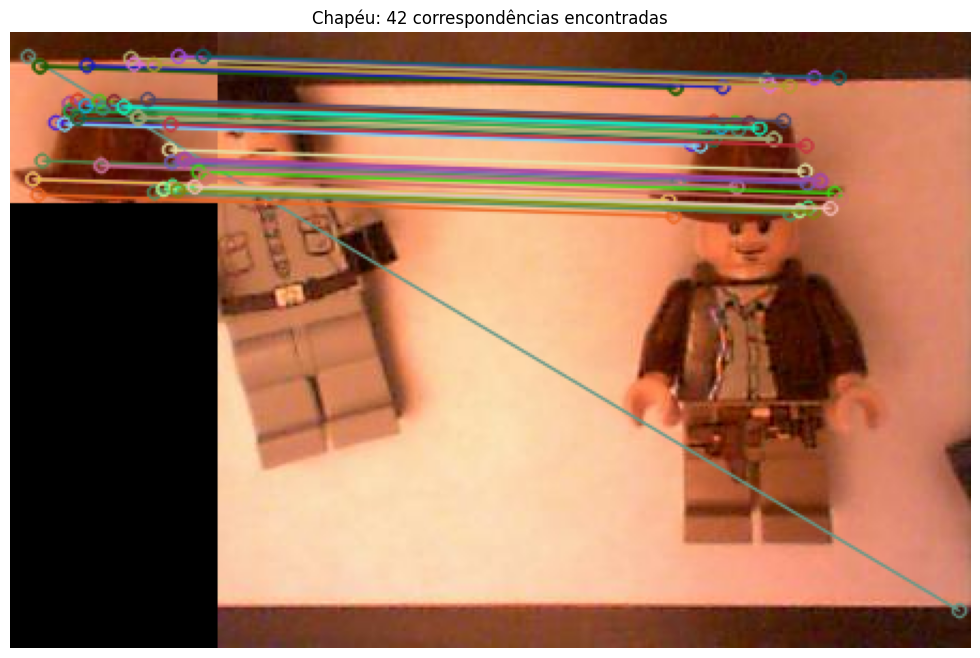


--- Face ---


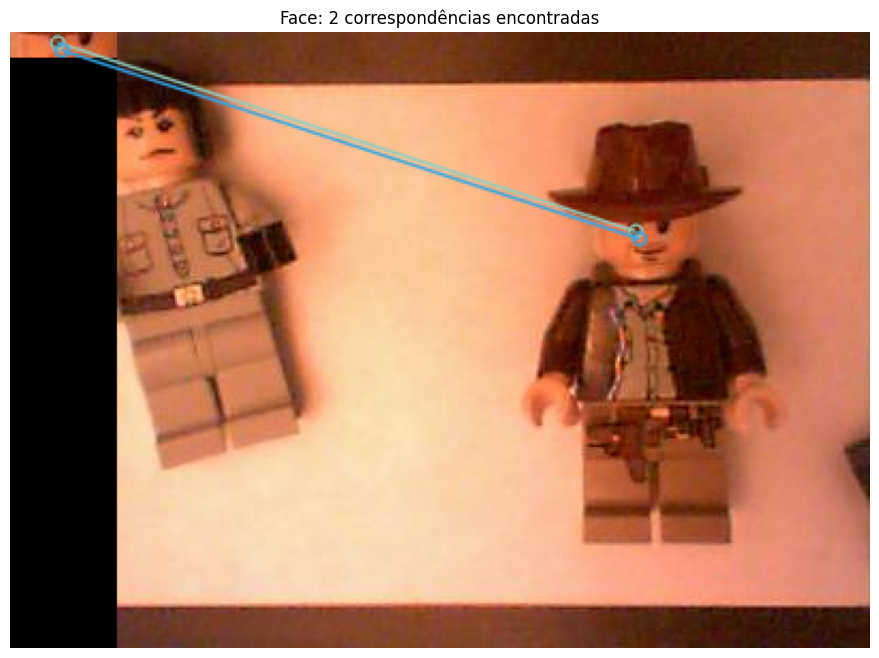


--- Cabeça ---


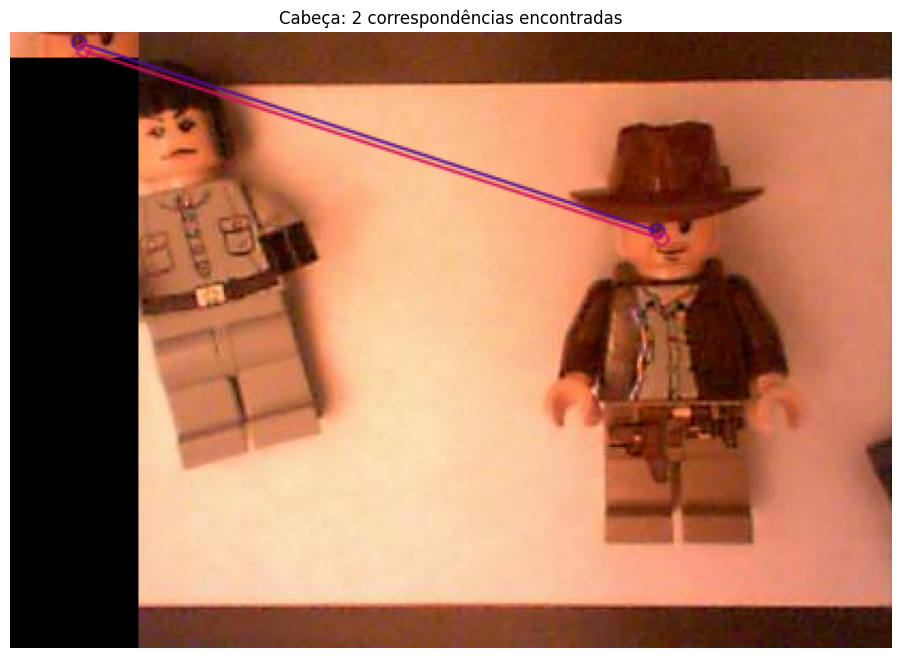


--- Braço ---


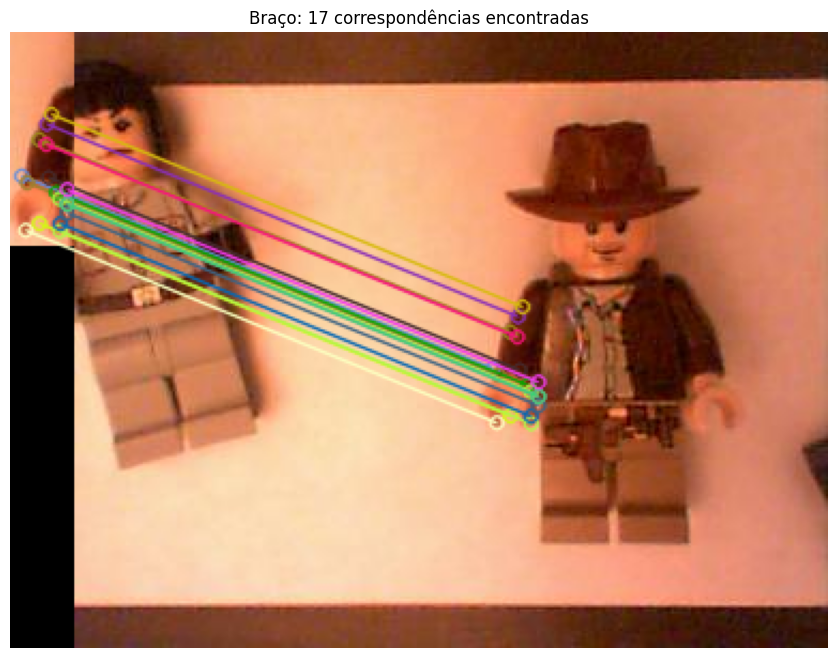


--- Corpo ---


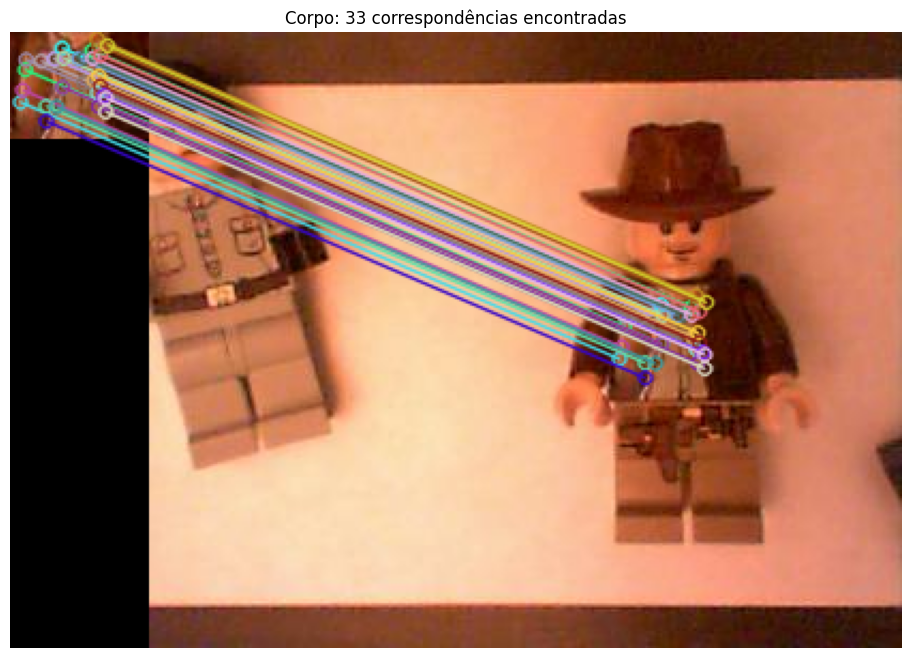


--- Mãos ---


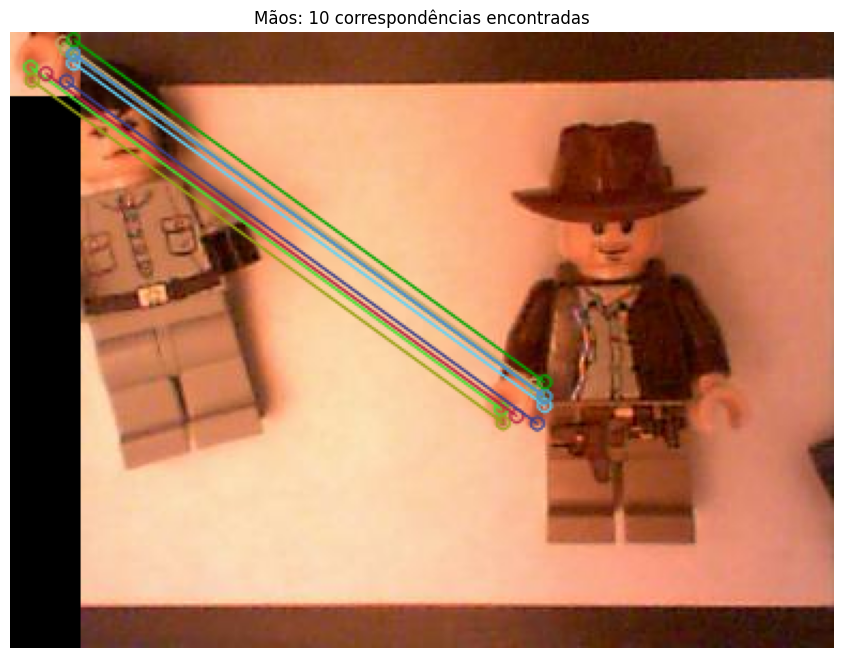


--- Pernas ---


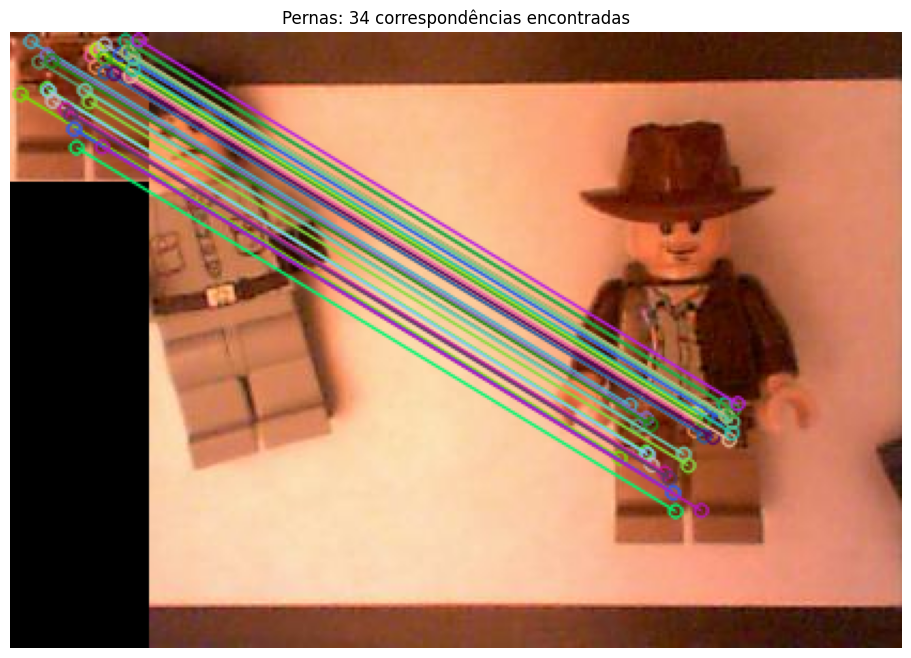


✅ Processamento do exemplo concluído!

💡 DICA: Para processar mais imagens, use:
   resultados = processar_imagens_test_csv(mostrar_todas=False, limite_visualizacao=3)


In [48]:
# Exemplo de uso: processar uma imagem específica com visualização completa
print("🎯 EXEMPLO: Processando uma imagem específica com visualização")

# Escolher uma imagem para demonstração
exemplo_arquivo = 'ajsdmvypg.jpg'
exemplo_caminho = os.path.join(pasta, exemplo_arquivo)

if os.path.exists(exemplo_caminho):
    resultado_exemplo = processar_imagem_com_visualizacao(exemplo_caminho, exemplo_arquivo, mostrar_matches=True)
    
    if resultado_exemplo:
        print(f"\n✅ Processamento do exemplo concluído!")
    else:
        print(f"\n❌ Erro no processamento do exemplo")
else:
    print(f"❌ Arquivo de exemplo {exemplo_arquivo} não encontrado")

print(f"\n{'='*60}")
print("💡 DICA: Para processar mais imagens, use:")
print("   resultados = processar_imagens_test_csv(mostrar_todas=False, limite_visualizacao=3)")
print(f"{'='*60}")